In [149]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
from tqdm import tqdm
import traceback
from typing import Dict, List, Optional


class WordBasedSimilarity:
    _word_count_col: str = None
    _word_count_threshold_col: str = None
    unique_col: str = None
    compare_col: str = None
    distance_threshold: float = None
    _duplicated_ids: list = None
    _duplicated_items: Dict[str, List] = None
    _similar_id_col: str = None

    def __init__(self, threshold_percent: float, unique_col: str, compare_col: str):
        self.threshold_percent = threshold_percent
        self.unique_col = unique_col
        self.compare_col = compare_col

    @staticmethod
    def calculate_jaccard_similarity(text1, text2):
        if not all(isinstance(i, str) for i in [text1, text2]):
            return 0.0

        set1 = set(text1.lower().split())
        set2 = set(text2.lower().split())
        intersection = len(set1.intersection(set2))
        union = len(set1.union(set2))
        return intersection / union if union != 0 else 0.0
    
    def get_similar(self, ddf: dd.DataFrame, only_max_similar: bool = False) -> dd.DataFrame:
        try:
            return self._get_similar(ddf, only_max_similar)
        except Exception as e:
            print(f"Error calculating similar values: {e}")
            traceback.print_exc()
            return None

    def _get_similar(self, ddf: dd.DataFrame, only_max_similar: bool):
        if self.threshold_percent < 0 or self.threshold_percent > 1:
            raise ValueError("Threshold percent must be between 0 and 1.")
        if self.unique_col not in ddf.columns or self.compare_col not in ddf.columns:
            raise ValueError(f"Columns {self.unique_col} or {self.compare_col} not found in DataFrame.")

        ddf = self._pre_process(ddf)

        # identify unique ids
        if not self._duplicated_ids:
            self._duplicated_ids = []
        self._duplicated_items = {k: self._get_similar_ids(ddf, k, only_max_similar) for k in tqdm(ddf[self.unique_col].compute(), desc="Processing unique ids")}
        self._duplicated_items = {k: v for k, v in self._duplicated_items.items() if v is not None}

        # Create Similar ID column
        self._similar_id_col = f"Similar {self.unique_col}"
        ddf[self._similar_id_col] = ""
        ddf[self._similar_id_col] = ddf[self._similar_id_col].astype(str)

        # assign similar values
        ddf = ddf.map_partitions(self._assign_similar_values, meta=ddf)
        ddf = ddf.drop(columns=[self._word_count_col, self._word_count_threshold_col], errors='ignore').persist()
        return ddf
    
    def _get_similar_ids(self, ddf: dd.DataFrame, unique_id: str, only_max_similar: bool) -> Optional[List[str]]:
        row = ddf[ddf[self.unique_col] == unique_id].compute()
        compare_value = row[self.compare_col].values[0]
        word_count_threshold = row[self._word_count_threshold_col].values[0]

        if unique_id in self._duplicated_ids:
            return None

        # Filter the DataFrame based on the word count threshold
        filtered_ddf: dd.DataFrame = ddf[(ddf[self._word_count_col] >= word_count_threshold)].copy()

        # Filter out duplicated ids
        filtered_ddf = filtered_ddf[~filtered_ddf[self.unique_col].isin(self._duplicated_ids)]

        if len(filtered_ddf) == 0:
            return None

        # Remove the current row from the filtered DataFrame
        filtered_ddf = filtered_ddf[filtered_ddf[self.unique_col] != unique_id]
        filtered_ddf = filtered_ddf.persist()

        if len(filtered_ddf) == 0:
            return None

        # Calculate Jaccard similarity for each compare value in the filtered DataFrame
        filtered_ddf['Similarity'] = filtered_ddf[self.compare_col].apply(
            lambda x: WordBasedSimilarity.calculate_jaccard_similarity(compare_value, x), meta=('x', 'f8'))

        threshold = self.threshold_percent
        if only_max_similar:
            # find the maximum similarity
            max_similarity = filtered_ddf['Similarity'].max().compute()
            threshold = max(self.threshold_percent, max_similarity)

        # find the record with maximum similarity
        similar_records = filtered_ddf[filtered_ddf['Similarity'] >= threshold]
        if len(similar_records) > 0:
            similar_ids = similar_records[self.unique_col].compute().values.tolist()
            self._duplicated_ids.append(unique_id)
            self._duplicated_ids.extend(similar_ids)
            return similar_ids
        return None
        
    def _assign_similar_values(self, _df: pd.DataFrame):
        for unique_id, similar_ids in self._duplicated_items.items():
            if not similar_ids:
                continue

            if unique_id not in similar_ids:
                similar_ids.append(unique_id)
            _df.loc[_df[self.unique_col].isin(similar_ids), self._similar_id_col] = unique_id
        return _df
        
    def _pre_process(self, ddf: dd.DataFrame) -> dd.DataFrame:
        ddf[self.compare_col] = ddf[self.compare_col].astype(str)
        ddf[self.unique_col] = ddf[self.unique_col].astype(str)

        # Remove duplicate values in the unique column
        print(f"Removing duplicates in '{self.unique_col}' column...")
        original_count = len(ddf)
        ddf = ddf.drop_duplicates(subset=[self.unique_col], keep='first')
        new_count = len(ddf)
        print(f"Removed {original_count - new_count} duplicates from '{self.unique_col}' column")

        print(f"Removing special characters from '{self.compare_col}' column")
        ddf[self.compare_col] = ddf[self.compare_col].str.replace(r'[^a-zA-Z0-9 ]', ' ', regex=True)

        # calculate word count for the compare column
        self._word_count_col = f"{self.compare_col}_WordCount"
        ddf[self._word_count_col] = ddf[self.compare_col].str.split().str.len()
        ddf[self._word_count_col] = ddf[self._word_count_col].fillna(0).astype(int)

        # calculate word count threshold
        self._word_count_threshold_col = f"{self._word_count_col}_Threshold"
        ddf[self._word_count_threshold_col] = np.ceil(ddf[self._word_count_col] * self.threshold_percent).astype(int)

        ddf = ddf.sort_values(by=self.unique_col, ascending=False).reset_index(drop=True).persist()

        return ddf


In [ ]:
from IPython.display import display
import time
import ctypes

file_path = r"C:\Users\RoopakPrajapat\Downloads\VendorMaster_50000.xlsx"
df = dd.from_pandas(pd.read_excel(file_path), npartitions=2)

perf_data = {}
for t in range(1000, len(df)+1000, 1000):
    start_time = time.time()
    # limit the number of rows to process
    temp_df= dd.from_pandas(df.head(t), npartitions=2)

    similarity_handler = WordBasedSimilarity(threshold_percent=0.75, unique_col='VendorNumber', compare_col='VendorName')
    temp_df = similarity_handler.get_similar(temp_df, only_max_similar=False)
    time_elapsed = time.time() - start_time
    perf_data[t] = time_elapsed
    print(f"Processed {t} rows in {time_elapsed:.2f} seconds.")

    temp_df.compute().to_excel(f'pairwise_distance_{t}.xlsx', index=False)
    # break



In [151]:
perf_data

{1000: 33.175803899765015,
 2000: 71.21207189559937,
 3000: 120.72941207885742,
 4000: 172.7958390712738,
 5000: 227.57850003242493,
 6000: 285.1220455169678}

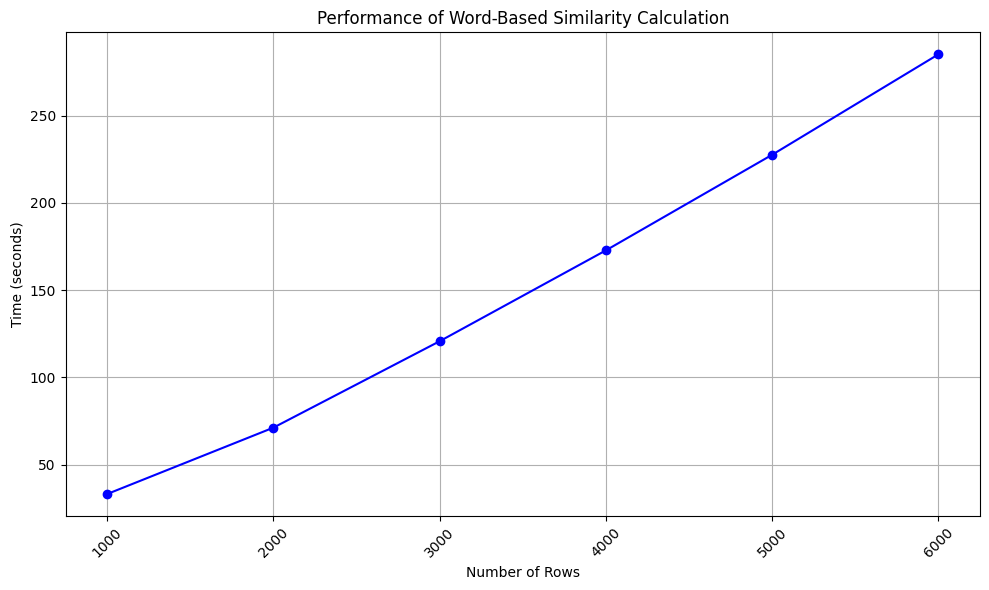

In [153]:
import matplotlib.pyplot as plt

df = pd.DataFrame.from_dict(perf_data, orient='index', columns=['Time'])
df.index.name = 'Number of Rows'
df.reset_index(inplace=True)
df['Time'] = df['Time'].astype(float)

# Plotting the performance data
plt.figure(figsize=(10, 6))
plt.plot(df['Number of Rows'], df['Time'], marker='o', linestyle='-', color='b')
plt.title('Performance of Word-Based Similarity Calculation')
plt.xlabel('Number of Rows')
plt.ylabel('Time (seconds)')
plt.grid()
plt.xticks(df['Number of Rows'], rotation=45)
plt.tight_layout()
plt.show()